# Business Card Reader

In [1]:
!pip3 install imutils
!pip3 install --upgrade imutils

!apt-get install tesseract-ocr
!pip3 install pillow
!pip3 install pytesseract

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (26.1 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading databas

In [0]:
import cv2
import imutils
import numpy as np

from PIL import Image
import pytesseract
import os

from matplotlib import pyplot as plt

In [3]:
!rm b_card*
!wget https://www.dropbox.com/s/7orn85msb3wip12/b_card1.jpg

rm: cannot remove 'b_card*': No such file or directory
--2020-04-28 06:25:07--  https://www.dropbox.com/s/7orn85msb3wip12/b_card1.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7orn85msb3wip12/b_card1.jpg [following]
--2020-04-28 06:25:08--  https://www.dropbox.com/s/raw/7orn85msb3wip12/b_card1.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2ccbbe6898c40f2767f073ca1b.dl.dropboxusercontent.com/cd/0/inline/A2uD5Z6UGMYaazEeFS_e6dX_NaTkq7Zyg4C2U6l19POJTvm_LRGKPz1W2xArCs3VEQiK8qtsUhvh5cxks-JAtyHu7oVyoQCb4yTrfhezuPqovA/file# [following]
--2020-04-28 06:25:08--  https://uc2ccbbe6898c40f2767f073ca1b.dl.dropboxusercontent.com/cd/0/inline/A2uD5Z6UGMYaazEeFS_e6dX_NaTkq7Zyg4C2U6l19POJTvm_LRGKPz1W2xArCs3VEQiK8qtsUhvh5cxk

## Processign Starts here ...

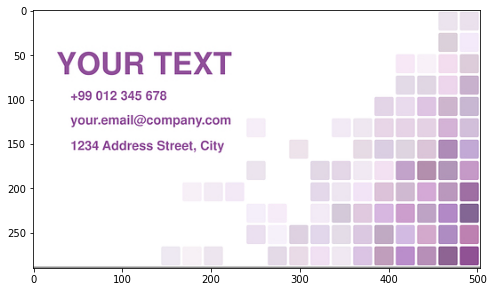

In [4]:
img = cv2.imread('b_card1.jpg')
plt.figure(figsize=(8, 8))
plt.imshow(img)

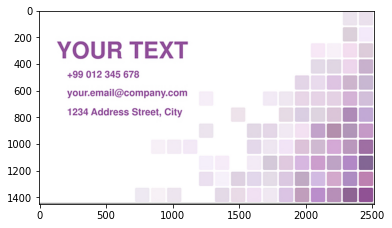

In [5]:
height, width = img.shape[:2]
res = cv2.resize(img,(5*width, 5*height), interpolation = cv2.INTER_CUBIC)
plt.imshow(res)

## Make it gray scale

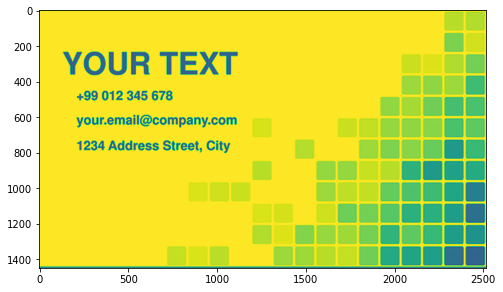

In [6]:
img_gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8, 8))
plt.imshow(img_gray)

## Dilate the image

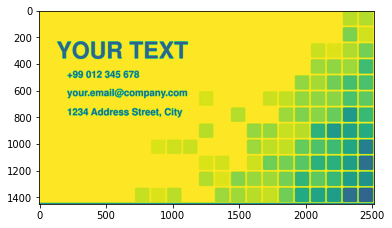

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
erode = cv2.morphologyEx(img_gray, cv2.MORPH_ERODE, kernel)
plt.imshow(erode)

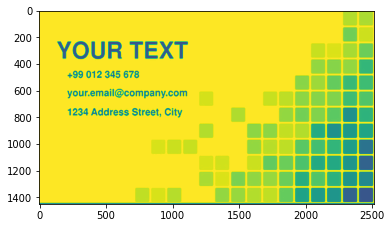

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 2))
dilate = cv2.morphologyEx(img_gray, cv2.MORPH_DILATE, kernel)
plt.imshow(dilate)

## Thresholding
Make white more white and black more black. 

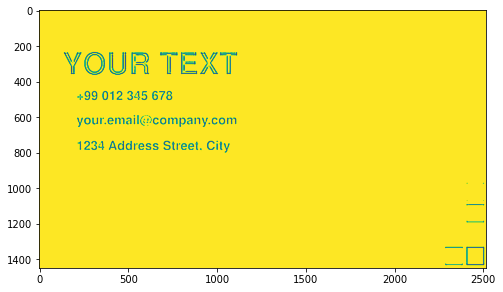

In [9]:
#_, binary_thresh = cv2.threshold(dilate, 200, 255, cv2.THRESH_BINARY_INV)
_, binary_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(8, 8))
plt.imshow(binary_thresh)

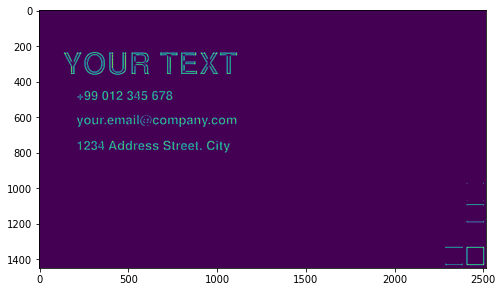

In [10]:
#_, binary_thresh = cv2.threshold(dilate, 200, 255, cv2.THRESH_BINARY_INV)
_, binary_thresh = cv2.threshold(erode, 100, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(8, 8))
plt.imshow(binary_thresh)

This is required to find countours, hence we make black->white and white->black.

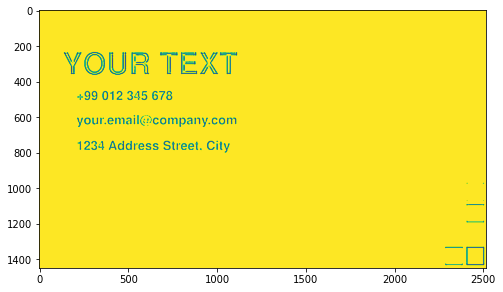

In [11]:
binary_thresh_negative = cv2.subtract(255, binary_thresh)
plt.figure(figsize=(8, 8))
plt.imshow(binary_thresh_negative)

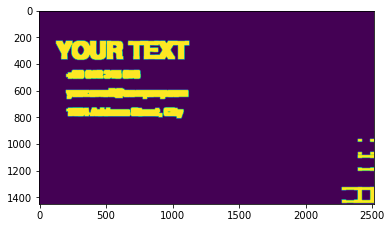

In [12]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 20))
dilate = cv2.morphologyEx(binary_thresh, cv2.MORPH_DILATE, kernel)
plt.imshow(dilate)

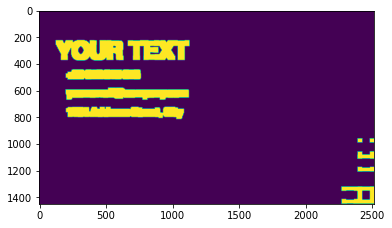

In [13]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 10))
dilate2 = cv2.morphologyEx(dilate, cv2.MORPH_DILATE, kernel)
plt.imshow(dilate2)

## Detect Lines
Find lines and their angle, so that we can rotate the image with the same angle. This is useful when we classify the image using Deep learning. 

In [14]:
lines = cv2.HoughLinesP(dilate2, 1, np.pi/180, 100, minLineLength= 300/2.0, maxLineGap=20)

angle = 0
for line in lines:
  x1, y1, x2, y2 = line[0]
  r = np.arctan2(y2 - y1, x2 - x1)
  angle += np.arctan2(y2 - y1, x2 - x1)
  
avg_radian = angle / len(lines)
avg_angle = avg_radian * 180 / np.pi

print ("Average angle is %f degrees" % avg_angle)


Average angle is -0.525747 degrees


In [0]:
def rotate_image(mat, angle):
  # angle in degrees

  height, width = mat.shape[:2]
  image_center = (width/2, height/2)

  rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

  abs_cos = abs(rotation_mat[0,0])
  abs_sin = abs(rotation_mat[0,1])

  bound_w = int(height * abs_sin + width * abs_cos)
  bound_h = int(height * abs_cos + width * abs_sin)

  rotation_mat[0, 2] += bound_w/2 - image_center[0]
  rotation_mat[1, 2] += bound_h/2 - image_center[1]

  rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
  return rotated_mat

### Rotate all the required images.

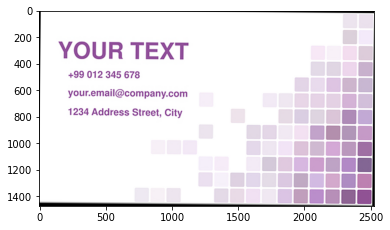

In [16]:
binary_thresh_negative = rotate_image(dilate2, avg_angle)
img = rotate_image(res, avg_angle)

plt.imshow(img)

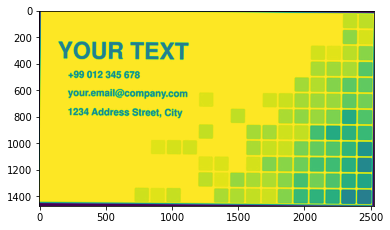

In [17]:
img_gray = rotate_image(img_gray, avg_angle)

plt.imshow(img_gray)

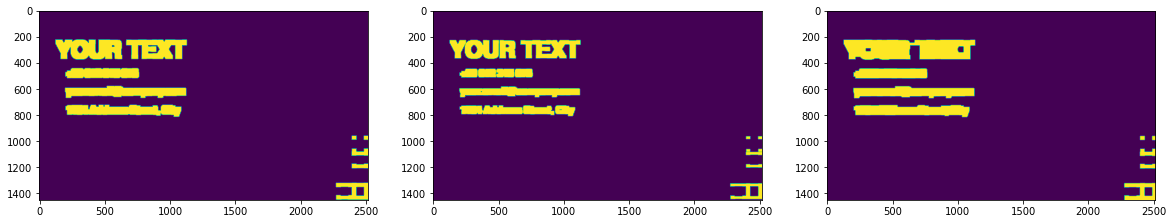

In [18]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 8))
connected = cv2.morphologyEx(dilate2, cv2.MORPH_CLOSE, kernel, iterations=2)
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(dilate2)
fig.add_subplot(1, 3, 2)
plt.imshow(dilate)
fig.add_subplot(1, 3, 3)
plt.imshow(connected)

In [21]:
contours, hierarchy = cv2.findContours(connected, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#pic, contours, hierarchy = cv2.findContours(connected, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

print("Number of contours: ", len(contours))
boxes = map(lambda c : cv2.boundingRect(c), contours)
filtered = filter(lambda b : b [2] > 20 and b [3] > 25, boxes)

Number of contours:  12


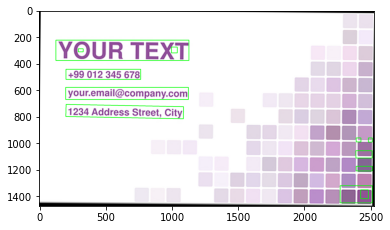

In [22]:
for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img = cv2.drawContours(img, [box], 0, (0,255,0), 3)

plt.imshow(img)

Idx 0  23291.500000
Idx 1  3815.000000
Idx 2  3888.500000
Idx 3  5184.000000
Idx 4  897.000000
Idx 5  1078.500000
Idx 6  62837.500000
Idx 7  61576.500000
Idx 8  41275.000000
Idx 9  132151.000000
Idx 10  842.000000
Idx 11  1802.000000


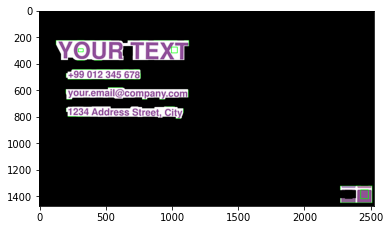

In [23]:
mask = np.zeros_like(img_gray) # Create mask where white is what we want, black otherwise

for idx in range(len(contours)):
  area = cv2.contourArea(contours[idx])
  print('Idx %d  %f' % (idx,area))
  if area > 10000:
    cv2.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask
  
out = np.zeros_like(img) # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

# Show the output image
plt.imshow(out)

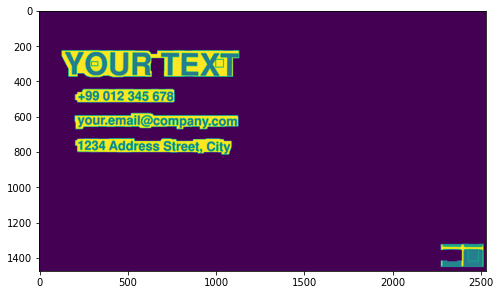

In [24]:
out_gray = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8, 8))
plt.imshow(out_gray)

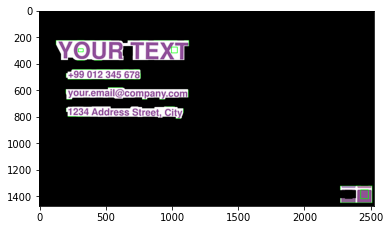

In [25]:
plt.imshow(out)

## OCR with Tesseract 

In [26]:
# write the grayscale image to disk as a temporary file so we can
# apply OCR to it
import os
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, out_gray)

text = pytesseract.image_to_string(Image.open(filename))
os.remove(filename)
print(text)

YOURSTEXT

+99 012 345 678

your.email@company.com

1234 Address Street, City
